In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, precision_score, recall_score,  f1_score
from preprocessing import encoding_sorted, encode_one_hot, prepare_existing_data, download_raw_data, add_features
from charts_and_write import *
from sklearn.ensemble import AdaBoostClassifier

# Adaboost classifier


Adaboost Classifier es un algortimo de clasificacion que busca crear varios arboles sencillos secuencialmente, con la idea de en cada iteracion ajustar lo que el anterior ajustó mal

## Preprocesamiento

En nuestro script preprocessing.py tenemos definidas ya funciones que nos van a servir para descargar los datos crudos y luego prepararlos para luego poder aplicarle ingeniería de features. La función prepararDatosExistentes 

In [70]:
download_raw_data()

In [128]:
#datasets train-test y holdout 
data_train = pd.read_csv("impuestos_train.cvs")
data_holdout = pd.read_csv("impuestos_holdout.cvs")
#llenamos los nulls y borramos columnas que no se usan
data_train, data_holdout = prepare_existing_data(data_train, data_holdout)


## Selección de features 1


Podemos usar los features que ya vienen en el dataset y ademas generar nuevos a partir de ellos. Para empezar de entrada vamos a descartar algunos que ya en el TP1 vimos que no aportaban como son barrio y educacion alcanzada. 
Luego, de los features ya existentes va a haber un grupo, los categoricos, que al no ser numericos vamos a tener que utilizar un encodeo para poder entrenar el modelo. La mayoria de ellos no tienen un orden entonces vamos a usar nuestra función de one hot encoding, que genera una columna nueva por cada valor posible. Para el caso de los que sí tienen orden vamos a utilizar un encodeo propio con la funcion "encoding_sorted". Ambas funciones estan en el script de preprocessing.py. Ademas, vamos a agregar un feature llamado working_years_higher_than_27 que es un booleano según si la persona trabajo mas de 27 horas en la semana. 


In [119]:
columns_one_hot = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "religion", "trabajo", "genero"]
data_train_v1 = encode_one_hot(data_train, columns_one_hot)
columns_sorted_numeric = ["educacion"]
data_train_v1 = encoding_sorted(data_train_v1, columns_sorted_numeric)
data_train_v1 = add_features(data_train_v1, ["working_years_higher_than_27"])


In [120]:
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = train_test_split(data_train_v1.drop(columns={"tiene_alto_valor_adquisitivo"}), data_train_v1["tiene_alto_valor_adquisitivo"], random_state=42)

## Selección de features 2

Para la segunda selección vamos a agregar features obtenidos a partir del analisis del TP1, que son la transformación de edad a decil y de gancnaias en bolsa a cuartil.
El feature edad lo vamos a reemplazar por el decil al que pertenece en el dataset de entrenamiento, y vamos a reemplazar el feature de ganancias y perdidas en la bolsa por uno "bolsa" que representará el cuartil al que pertenece, en caso de ganancia, 0 en caso de no tener actividad, y un valor negativo correspondiente al cuartil en el caso de perdidas. Así, los casos que mas perdida tienen van a tener el valor -4, y los que mas ganancia tienen van a tener el valor 4.


In [74]:
columns_one_hot = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "religion", "trabajo", "genero"]
data_train_v2 = encode_one_hot(data_train,columns_one_hot)
columns_sorted_numeric = ["educacion", "edad", "bolsa"]
data_train_v2 = encoding_sorted(data_train_v2, columns_sorted_numeric)


In [75]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(data_train_v2.drop(columns={"tiene_alto_valor_adquisitivo"}), data_train_v2["tiene_alto_valor_adquisitivo"], random_state=42)

## Prueba AdaBoost por defecto 
Vamos primero a correr adaboost classifier con hiperparametros por defecto y ver como performa, así luego al hacer random y grid search

### Seleccion 1

In [76]:
clf = AdaBoostClassifier()
clf.fit(X_train_v1, y_train_v1)
results_cv = cross_validate(clf, X_train_v1, y_train_v1, cv=5, scoring=['precision', "recall", "accuracy", "roc_auc", "f1"])
#metricas cross validation en set de train
show_cv_metrics(results_cv)

Accuracy: 0.8588452088452087
----------------------------------------------
Precision: 0.7597670806740513
----------------------------------------------
Recall: 0.6102465411719609
----------------------------------------------
Auc Roc score: 0.913905033220024
----------------------------------------------


In [77]:
#metricas para set test

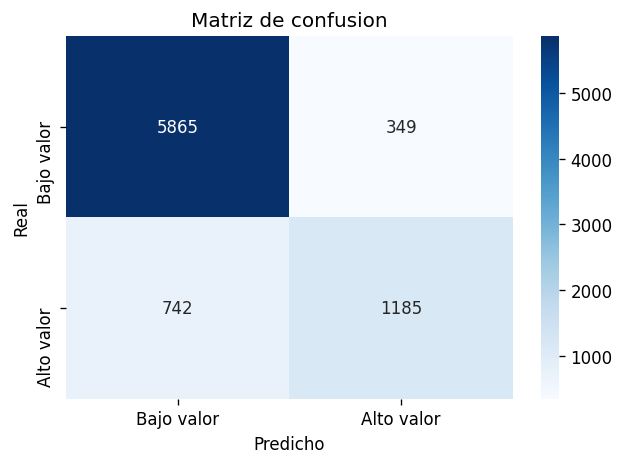

In [78]:
y_pred = clf.predict(X_test_v1)
show_confusion_matrix(y_pred,y_test_v1)

In [79]:
show_metrics(clf, y_pred, y_test_v1, X_test_v1, "adaboost")

Accuracy: 0.8659869794865496
----------------------------------------------
Precision: 0.6149455111572393
----------------------------------------------
Recall: 0.772490221642764
----------------------------------------------
F1_score: 0.6847731869401907
----------------------------------------------
AUC-ROC score para adaboost: 0.918


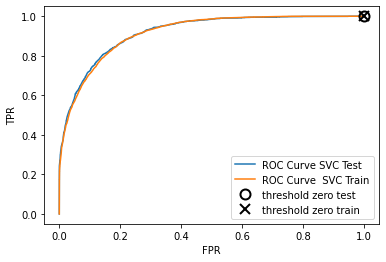

In [80]:
show_roc_curve(clf,"SVC",X_test_v1, X_train_v1, y_test_v1, y_train_v1)

### Seleccion 2

In [81]:
clf = AdaBoostClassifier()
clf.fit(X_train_v2, y_train_v2)
crossval_scores = cross_val_score(clf, X_train_v2, y_train_v2, scoring='roc_auc', cv=10)
#metricas cross validation en set de train
show_cv_metrics(results_cv)

Accuracy: 0.8588452088452087
----------------------------------------------
Precision: 0.7597670806740513
----------------------------------------------
Recall: 0.6102465411719609
----------------------------------------------
Auc Roc score: 0.913905033220024
----------------------------------------------


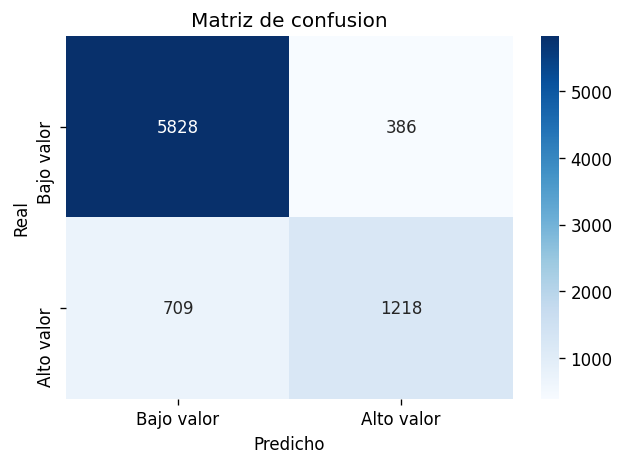

In [82]:
y_pred = clf.predict(X_test_v2)
show_confusion_matrix(y_pred,y_test_v2)

In [83]:
show_metrics(clf, y_pred, y_test_v2, X_test_v2, "adaboost")

Accuracy: 0.8654956393563444
----------------------------------------------
Precision: 0.6320705760249092
----------------------------------------------
Recall: 0.7593516209476309
----------------------------------------------
F1_score: 0.6898895497026339
----------------------------------------------
AUC-ROC score para adaboost: 0.917


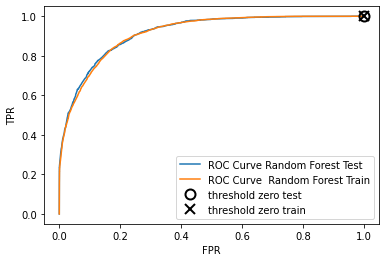

In [84]:
show_roc_curve(clf,"Random Forest",X_test_v2, X_train_v2, y_test_v2, y_train_v2)

## Buscamos los mejores rangos de hiperparametros con Randomized Search Cross Validation y Grid Search para ambas selecciones

Vamos a utilizar randomized search para buscar el rango de valores posibles para hiperparametros para luego hacer un grid search.

### Randomized Search Cross Validation Seleccion 1


In [85]:
param_random = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                'learning_rate': [0.001, 0.01, 0.1, 1, 2],
                'algorithm': ['SAMME', 'SAMME.R']}

In [86]:
clf = AdaBoostClassifier()
random_search = RandomizedSearchCV(clf, param_distributions = param_random, random_state=0)
random_search.fit(X_train_v1, y_train_v1)

RandomizedSearchCV(estimator=AdaBoostClassifier(),
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': [0.001, 0.01, 0.1, 1,
                                                          2],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=0)

In [87]:
random_search.best_params_

{'n_estimators': 70, 'learning_rate': 1, 'algorithm': 'SAMME.R'}

###  Grid Search Cross Validation Seleccion 1

Para el cross validation vamos a usar 5 folds. 
En el param grid usamos valores de hiperparametros cercanos a los obtenidos como best params en random search.
Para que el grid search decida cual es la mejor combinacion vamos a utilizar roc auc como metrica.

In [88]:
param_grid = {'n_estimators':  [60, 70, 80,],
                'learning_rate': [ 0.1, 1, 2],
                'algorithm': ['SAMME.R']}

In [89]:
clf = AdaBoostClassifier()
grid_search = GridSearchCV(estimator=clf,
                     param_grid=param_grid,
                     scoring='roc_auc',
                     cv=5,
                     n_jobs=-1)

In [90]:
grid_search.fit(X_train_v1, y_train_v1)


GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['SAMME.R'], 'learning_rate': [0.1, 1, 2],
                         'n_estimators': [60, 70, 80]},
             scoring='roc_auc')

In [91]:
best_parameters = grid_search.best_params_
print(best_parameters)

{'algorithm': 'SAMME.R', 'learning_rate': 1, 'n_estimators': 80}


### Randomized Search Cross Validation Seleccion 1


In [ ]:
param_random = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                'learning_rate': [0.001, 0.01, 0.1, 1, 2],
                'algorithm': ['SAMME', 'SAMME.R']}

In [ ]:
clf = AdaBoostClassifier()
random_search = RandomizedSearchCV(clf, param_distributions = param_random, random_state=0)
random_search.fit(X_train_v2, y_train_v2)

In [ ]:
random_search.best_params_

###  Grid Search Cross Validation Seleccion 2


In [ ]:
param_grid = {'n_estimators':  [60, 70, 80,],
                'learning_rate': [ 0.1, 1, 2],
                'algorithm': ['SAMME.R']}

In [ ]:
clf = AdaBoostClassifier()
grid_search = GridSearchCV(estimator=clf,
                     param_grid=param_grid,
                     scoring='roc_auc',
                     cv=5,
                     n_jobs=-1)

In [ ]:
grid_search.fit(X_train_v2, y_train_v2)


In [ ]:
best_parameters = grid_search.best_params_
print(best_parameters)

## Probamos los resultados de grid search en nuestros datasets

### Seleccion 1

In [92]:
best_clf = AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 1, n_estimators= 80)
best_clf.fit(X_train_v1, y_train_v1)

AdaBoostClassifier(learning_rate=1, n_estimators=80)

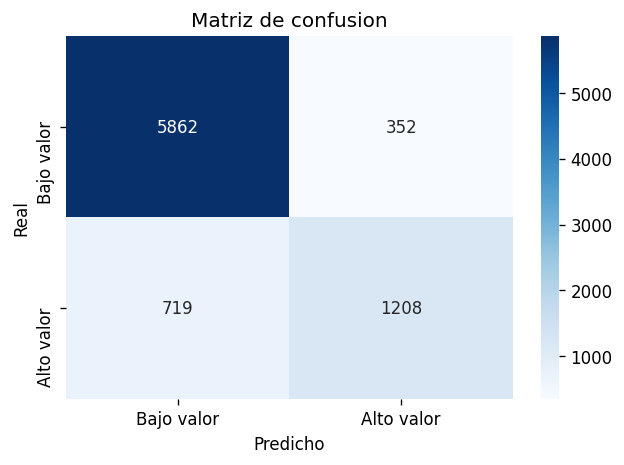

In [93]:
y_pred = best_clf.predict(X_test_v1)
show_confusion_matrix(y_pred,y_test_v1)

In [94]:
show_metrics(best_clf, y_pred, y_test_v1, X_test_v1, "adaboost")

Accuracy: 0.8684436801375752
----------------------------------------------
Precision: 0.6268811624286456
----------------------------------------------
Recall: 0.7743589743589744
----------------------------------------------
F1_score: 0.6928591912819042
----------------------------------------------
AUC-ROC score para adaboost: 0.922


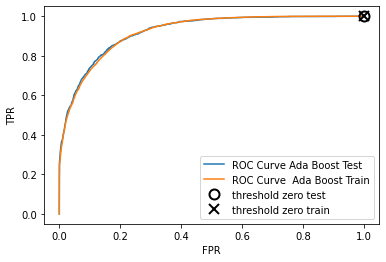

In [95]:
show_roc_curve(best_clf,"Ada Boost",X_test_v1, X_train_v1, y_test_v1, y_train_v1)

### Seleccion 2

In [96]:
best_clf = AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 1, n_estimators= 80)
best_clf.fit(X_train_v2, y_train_v2)

AdaBoostClassifier(learning_rate=1, n_estimators=80)

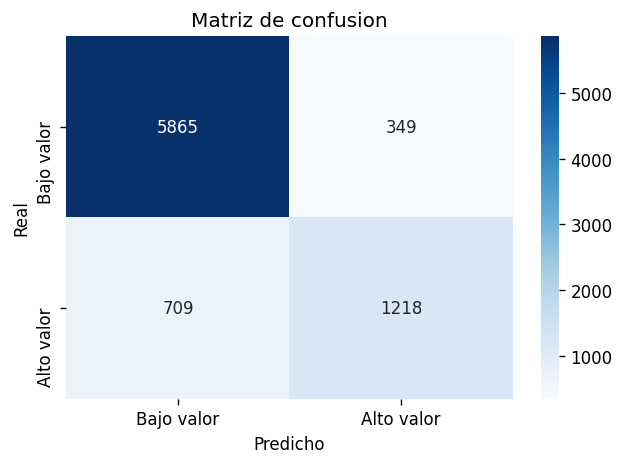

In [97]:
y_pred = best_clf.predict(X_test_v2)
show_confusion_matrix(y_pred,y_test_v2)

In [98]:
show_metrics(best_clf, y_pred, y_test_v2, X_test_v2, "adaboost")

Accuracy: 0.8700405355607419
----------------------------------------------
Precision: 0.6320705760249092
----------------------------------------------
Recall: 0.7772814294830888
----------------------------------------------
F1_score: 0.6971951917572983
----------------------------------------------
AUC-ROC score para adaboost: 0.921


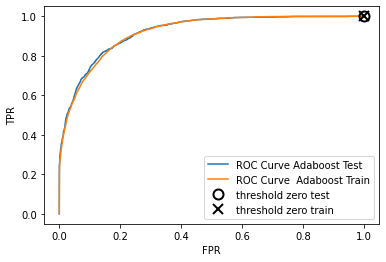

In [99]:
show_roc_curve(best_clf,"Adaboost",X_test_v2, X_train_v2, y_test_v2, y_train_v2)

### Resultado

El modelo que mejor performó fue el de la seleccion 1 usando los mejores parametros obtenidos con grid search

In [129]:
columns_one_hot = ["estado_marital", "categoria_de_trabajo", "rol_familiar_registrado", "religion", "trabajo", "genero"]
data_holdout = encode_one_hot(data_holdout, columns_one_hot)
columns_sorted_numeric = ["educacion"]
data_holdout = encoding_sorted(data_holdout, columns_sorted_numeric)
data_holdout = add_features(data_holdout, ["working_years_higher_than_27"])

In [131]:
best_clf = AdaBoostClassifier(algorithm= 'SAMME.R', learning_rate= 1, n_estimators= 80)
best_clf.fit(X_train_v1, y_train_v1)
predicciones_holdout = best_clf.predict(data_holdout.drop(columns=["id"]))

In [132]:
write_predictions (predicciones_holdout,"adaboost",data_holdout["id"])
